# Linear-Regression Betas — From Numbers to Meaning  
**Author:** Max Wienandts  

> **Why this notebook?**  
> You already know *how* to estimate coefficients — the full derivations and Python code live in:  
> • GitHub <https://github.com/MaxWienandts/Linear_Regression_OLS_vs_Gradient_Descent>  
> • Medium <https://medium.com/@maxwienandts/understanding-linear-regression-statistical-vs-machine-learning-approaches-08a5a5b04bbe>  
>   
> **This notebook is about turning β̂ into insight.** We tackle three practical questions for every coefficient:  
> 1. **What does it mean?** How scaling, logging, standardising, or interacting variables changes interpretation.  
> 2. **How uncertain is it?** Compare classical OLS, heteroskedasticity-robust (HC1), and bootstrap standard errors side by side.  
> 3. **Is it statistically relevant?** See how *t*-tests, HC1-robust tests, and bootstrap confidence intervals alter the verdict.  
>   
> Master these mechanics and you will:  
> * design experiments and pick units that make coefficients intuitive,  
> * explain elasticities and marginal effects to non-technical stakeholders,  
> * keep confidence intervals meaningful after common data transformations.  
>   
> **Key takeaway:** A regression coefficient is only as valuable as your grasp of its scale, uncertainty, and context. Let’s make every β tell a story you can defend.





In [22]:
import numpy as np, pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
import statsmodels.api as sm
from pathlib import Path

from sklearn.utils import resample

In [2]:
def load_demo():
    # Tiny dataset: TV/Radio/Newspaper ad spend -> Sales (classic ISLR example)
    return pd.read_csv(
        "https://github.com/JWarmenhoven/ISLR-python/raw/master/Notebooks/Data/Advertising.csv",
        index_col=0
    )

# Adds a constant in the design matrix (typically for the intercept term in linear regression)
def add_constant(X):  # convenience wrapper
    return sm.add_constant(X, has_constant="add")

df = load_demo()
df

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
...,...,...,...,...
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5


## Initial Checks
I am not focusing on exploratory data analysis (EDA) in this notebook. However, I will perform some basic data checks to identify any potential issues with the dataset.

Specifically, I want to verify:
- that all data types are correct (e.g., no unexpected characters in numeric variables),
- that there are no missing values,
- and that the variables exhibit some variance.

In [3]:
# Missing values
df_missing = pd.DataFrame(df.isna().sum(), columns = ['missing_values'])
df_missing['percent'] = df_missing['missing_values'] / len(df)
df_missing.head(50)

,missing_values,percent
TV,0,0.0
Radio,0,0.0
Newspaper,0,0.0
Sales,0,0.0


In [4]:
# Describe
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


## Baseline: levels → levels  

For a simple linear model   

$
y_i = \beta_0 + \beta_1 x_{1i} + \dots + \beta_p x_{pi} + \varepsilon_i,
$

`β_j` is the **marginal change in the mean of `y` when `x_j` increases by one unit, holding other predictors fixed.**


In [5]:
X = add_constant(df[["TV","Radio","Newspaper"]])
y = df["Sales"]

model = sm.OLS(y, X).fit()
model.summary().tables[1]   # coefficient table


,coef,std err,t,P>|t|,[0.025,0.975]
const,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
Radio,0.1885,0.009,21.893,0.000,0.172,0.206
Newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


## Interpreting the OLS Coefficient Table

| Variable      | β̂ (coef) | Std. Err. | *t*-stat | *p*-value | 95 % CI            |
|---------------|----------:|----------:|---------:|----------:|-------------------:|
| **Intercept** | 2.9389    | 0.312     |  9.42    | <0.001    | [ 2.324, 3.554 ]   |
| **TV**        | 0.0458    | 0.001     | 32.81    | <0.001    | [ 0.043, 0.049 ]   |
| **Radio**     | 0.1885    | 0.009     | 21.89    | <0.001    | [ 0.172, 0.206 ]   |
| **Newspaper** | −0.0010   | 0.006     | −0.18    | 0.860     | [ −0.013, 0.011 ]  |

> **Note:** All monetary inputs are in **thousands of dollars**, and the target variable *Sales* is in **thousands of units**.

---

### 1. Intercept (β₀ = 2.94)

* **Meaning:** Predicted average sales (~2.94 k units) when spending on **TV, Radio, and Newspaper is \$0 k**.  
* **Practicality:** Because zero advertising is outside the usual operating range, treat this as a baseline constant—not a target for decision making.  
* **Precision:** Tight CI ([2.32, 3.55]) and a very small *p*-value (<0.001) indicate the intercept is precisely estimated.

---

### 2. TV Advertising (β₁ = 0.0458)

* **Interpretation:**  
  *Each additional \$1 k spent on TV ads is associated with an average increase of **≈ 45.8 units** in sales, holding Radio and Newspaper budgets fixed.*  
  (0.0458 k units ≈ 45.8 units.)
* **Economic impact:** To gain one extra unit sold, you need roughly \$21.8 ( = \$1 000 / 45.8 ) in TV spend, assuming linearity.  
* **Statistical strength:**  
  * **t = 32.8** and **p < 0.001** → extremely strong evidence that TV spend matters.  
  * 95 % CI [0.043, 0.049] is narrow, implying high precision (relative SE ≈ 2 %).  
* **Variance note:** The tiny standard error (0.001) comes from a large sample and low multicollinearity.

---

### 3. Radio Advertising (β₂ = 0.1885)

* **Interpretation:**  
  *Each extra \$1 k on Radio ads correlates with **≈ 188.5 units** more sales, ceteris paribus.*  
* **Relative effectiveness:** Radio’s marginal effect is roughly **4 ×** that of TV here, but beware unit‐cost differences and possible diminishing returns.  
* **Significance:**  
  * **t = 21.9**, **p < 0.001** → highly significant.  
  * CI [0.172, 0.206] comfortably excludes zero.  
* **Business takeaway:** Radio is a consistently strong lever in this data set.

---

### 4. Newspaper Advertising (β₃ = −0.0010)

* **Interpretation:** Nominally, spending on newspapers shows a negligible **−1 unit** change per \$1 k, but…  
* **Statistical verdict:**  
  * **t = −0.18**, **p = 0.86** → no evidence of an effect.  
  * CI spans both negative and positive values ([−0.013, 0.011]).  
* **Practical advice:**  
  * Cannot reject H₀ (β₃ = 0). Newspaper spend may be redundant *after* controlling for TV and Radio.  
  * Drop the variable, check for interactions, or gather more data before reallocating budget.

---

### 5. How to read the remaining columns

| Column        | Purpose                                                         | Rule of Thumb                                          |
|---------------|-----------------------------------------------------------------|--------------------------------------------------------|
| **Std. Err.** | Estimated sampling variability of β̂                            | Smaller SE ⇒ more precise estimate                     |
| **t-stat**    | β̂ / SE                                                         | \|t\| ≳ 2 ⇒ often “significant” at the 5 % level       |
| ** P > \|t\|**   | Probability of observing a \|t\| this large (or larger) if H₀: β = 0 | *p* < 0.05 ⇒ reject H₀                                 |
| **95 % CI**   | Range where the true β falls with 95 % confidence (given assumptions) | If CI excludes 0, effect is “statistically significant” |


---

### 6. Caveats & Best Practices

* **Linearity & additivity:** Coefficients assume a linear, additive effect; investigate interactions or non-linear terms if warranted.  
* **Extrapolation danger:** Interpret within the data range (e.g., don’t predict sales at \$1 M newspaper spend).  
* **Omitted-variable bias:** If relevant ad channels or seasonality are missing, β̂’s may be biased.  
* **Heteroskedasticity:** If error variance isn’t constant, use robust (HC1) SEs; effect sizes remain the same, but significance could change.  
* **Practical vs. statistical significance:** A tiny but highly significant β might be economically irrelevant (or vice-versa). Always couple numbers with domain context.

---

**Bottom line:**  
*TV and Radio budgets drive sales in this dataset, while Newspaper appears superfluous once the other channels are included.*  
Use the β’s for **marginal ROI calculations**, but validate assumptions and refresh the model as new campaigns roll out.


## Standardising the predictors $X$

### Why bother?

* **Comparability** — Raw coefficients mix “economic strength” with units of measure.  
  A TV-spend coefficient expressed in thousands of dollars, a Radio coefficient also in thousands of dollars, and a Newspaper coefficient measured in column-inches cannot be compared directly.
  **Z-scoring** puts every predictor on the *same yard-stick: one standard-deviation (SD) move*.

* **Numerical stability** — Very large or tiny units inflate the condition number of $X^{\!\top}X$, making the matrix inversion noisy; standardising rescales values to roughly $[-3,3]$.

* **Regularisation & priors** — Ridge, Lasso, and many Bayesian priors assume predictors live on a common scale; z-scores satisfy this requirement.

---

### How it is done

For each predictor (column) $x_j$  

$
x'_{\,ji} \;=\; \dfrac{x_{ji}-\bar{x}_j}{s_j},\qquad
\bar{x}_j=\dfrac{1}{n}\sum_{i=1}^{n}x_{ji},\qquad
s_j=\sqrt{\dfrac{1}{n}\sum_{i=1}^{n}(x_{ji}-\bar{x}_j)^2}.
$

*Subtract the sample mean, then divide by the sample SD.*  
The intercept absorbs the centring term, so predictions back on the original scale remain unchanged.

---

### Interpreting the new coefficients

| Scale | “One-unit” change means … | Practical reading of $\hat{\beta}_j$ |
|-------|---------------------------|--------------------------------------|
| **Original** | +\$1 k in TV spend | Change in sales (k units) per \$1 k |
| **Standardised** | +1 SD in TV (≈ $s_{\text{TV}}$ k) | Change in sales per **one SD** increase |

After standardising, the larger the absolute value of $\hat{\beta}_j$, the stronger the predictor’s partial association, because all predictors now share the same ±1 scale.

---

### Effect on standard errors and *t*-tests

If scaled predictors were perfectly **orthogonal** (rare in practice),

$\operatorname{Var}(\hat{\beta}'_j)=\sigma^{2}/n$,

so every coefficient would have the **same** SE.  
With real-world correlation, the familiar matrix formula

$\operatorname{Var}(\hat{\boldsymbol{\beta}}')=\sigma^{2}(X'^{\!\top}X')^{-1}$

still applies, but the diagonal values are now driven by *collinearity* rather than disparate units.

> **Important:** Because both $\hat{\beta}_j$ **and** its SE are divided by the same constant, *t*-statistics and p-values **do not change** relative to the unscaled model.

---

### When *not* to standardise

* Stakeholders need **direct dollar-for-dollar interpretation** (“\$1 k in TV buys 46 extra units”).  
* Logistic/Poisson models where odds ratios or incidence-rate ratios must stay in raw units.  
* Business rules or profit functions downstream require original units.

---

**Bottom line:** Z-scoring the columns of $X$ reveals relative effect sizes, improves numerical conditioning, and leaves statistical inference unchanged. Use it whenever cross-unit comparability is more valuable than raw-unit storytelling.



In [6]:
X_std = add_constant((df[["TV","Radio","Newspaper"]] - df[["TV","Radio","Newspaper"]].mean()) /
                     df[["TV","Radio","Newspaper"]].std(ddof=0))
model_std = sm.OLS(y, X_std).fit()
model_std.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
const,14.0225,0.119,117.655,0.000,13.787,14.258
TV,3.9193,0.119,32.809,0.000,3.684,4.155
Radio,2.7921,0.128,21.893,0.000,2.541,3.044
Newspaper,-0.0225,0.128,-0.177,0.860,-0.274,0.229


### Coefficients after **z-scoring** the predictors

| Variable      | β̂ (coef) | Std. Err. | *t*  | *p*   | 95 % CI          |
|---------------|----------:|----------:|-----:|------:|-----------------:|
| **Intercept** | 14.0225   | 0.119 | 117.66 | < 0.001 | [13.787, 14.258] |
| **TV (1 SD)** | 3.9193    | 0.119 | 32.81 | < 0.001 | [ 3.684, 4.155 ] |
| **Radio (1 SD)** | 2.7921 | 0.128 | 21.89 | < 0.001 | [ 2.541, 3.044 ] |
| **Newspaper (1 SD)** | −0.0225 | 0.128 | −0.18 | 0.872 | [ −0.274, 0.229 ] |

**What the scaling means**

* Each predictor column was centred and divided by its own sample standard deviation (SD).  
* A “one-unit” change in TV or Radio now means **one full SD**, not one thousand dollars.  
  *For the Advertising data, one SD in TV spend ≈ 85 k dollars, one SD in Radio ≈ 17 k dollars, and one SD in Newspaper ≈ 22 column-inches.*

---

#### Intercept (14.02 k units)

* Equal to the **mean Sales** in the sample.  
* Simply tells us the average outcome when every predictor is at its mean (because the z-scores are zero there).  
* Extremely precise (*t* ≈ 118) because it is just the sample mean of Sales.

#### TV (3.92 k units per 1 SD)

* Increasing TV spend by **one SD** is associated with about **3 943 additional units** sold, holding Radio and Newspaper constant.  
* Tight confidence interval (3.68 k – 4.16 k) and huge *t*-value show a very strong, precisely estimated effect.

#### Radio (2.79 k units per 1 SD)

* One SD bump in Radio advertising lifts sales by **about 2 792 units**.  
* Still highly significant but the effect is smaller than TV once both are on the same SD scale.

#### Newspaper (−23 units per 1 SD)

* Effect is essentially zero: the interval −274 to 229 units spans zero comfortably and *p* = 0.87.  
* After controlling for TV and Radio, extra newspaper coverage does not predict higher sales.

---

**Why the numbers matter**

* **Magnitude ranking is now fair**: TV (3.9 k) > Radio (2.8 k) ≫ Newspaper (0).  
  Scaling removed the hidden unit effect, revealing that TV is the strongest driver per SD of budget variance.
* **Statistical conclusions are unchanged**: newspaper remains non-significant, but z-scaling lets us compare practical importance directly.
* **Use cases**: when you feed these coefficients into regularised or ensemble models, the similar scales keep optimisation well-behaved.


## Logarithmic transformations — why and how to interpret the coefficients

Logarithms are the work-horse transformation for **multiplicative** relationships: \
they turn products into sums and growth rates into slope coefficients. \
Below are the two most common log-regression forms and how to read $\beta_1$ in
each case.

---

### Level → log($y$)    (*log-level or semi-log model*)

$\displaystyle
\ln y_i = \beta_0 + \beta_1 x_{1i} + \varepsilon_i
$

| Aspect | What it means |
|--------|---------------|
| Units of $x_1$ | Unchanged (e.g. dollars, kilograms). |
| Units of $y$   | Natural log of $y$ (dimensionless). |
| **Interpretation of $\beta_1$** | *Approximate* **percentage change** in $y$ when $x_1$ rises by one unit. <br> Rule of thumb for small effects: $\Delta\ln y \approx \%\Delta y$. |
| Exact back-transform | For a one-unit increase in $x_1$: <br> $\%\,\Delta y = \bigl(e^{\beta_1} - 1\bigr)\times 100\%$. <br> (Use this when $|\beta_1|$ is not “small”.) |
| Typical use-case | Converting a right-skewed positive target (sales, income, counts) into an approximately symmetric variable, stabilising variance. |

---

### log($y$) → log($x$)    (*log-log or elasticity model*)

$\displaystyle
\ln y_i = \beta_0 + \beta_1 \,\ln x_{1i} + \varepsilon_i
$

| Aspect | What it means |
|--------|---------------|
| Units of $x_1$ | Also logged (dimensionless). |
| Units of $y$   | Logged (dimensionless). |
| **Interpretation of $\beta_1$** | **Elasticity**: the *percentage change* in $y$ resulting from a **1 percent change** in $x_1$. |
| Exact back-transform | For a 1 % increase in $x_1$: <br> $\%\,\Delta y \approx \beta_1$ (because $\ln(1.01)\approx0.01$). |
| Typical use-case | Price elasticity of demand, advertising elasticities, Cobb-Douglas production functions, etc. |

---

### Practical tips and caveats

* **$y$ and $\ln y$ require $y>0$.** Add a small constant or use a Box–Cox
  transform when zeros are present.
* **Large effects** — When $|\beta_1| > 0.1$, rely on the exact
  back-transform $e^{\beta_1}-1$ instead of the linear
  approximation.
* **Heteroskedasticity** often improves after logging the dependent
  variable, but robust/HC standard errors are still wise.
* **Comparing models** — You can’t compare $R^2$ between a level and a log
  model; use information criteria (AIC, BIC) or out-of-sample metrics.


In [7]:
df_log = df.copy()
df_log["log_Sales"] = np.log(df_log["Sales"])
df_log["log_TV"]    = np.log(df_log["TV"]+1)  # avoid log(0)
df_log["log_Radio"]    = np.log(df_log["Radio"]+1)  # avoid log(0)
df_log["log_Newspaper"]    = np.log(df_log["Newspaper"]+1)  # avoid log(0)

# log-level or semi-log model
X = add_constant(df[["TV","Radio","Newspaper"]])
y_log    = df_log["log_Sales"]

model_log = sm.OLS(y_log, X).fit()
model_log.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
const,1.7390,0.035,50.300,0.000,1.671,1.807
TV,0.0037,0.000,23.735,0.000,0.003,0.004
Radio,0.0118,0.001,12.365,0.000,0.010,0.014
Newspaper,0.0004,0.001,0.545,0.587,-0.001,0.002


### Log‐level model:  ln(Sales) ~ TV + Radio + Newspaper

| Predictor       | β̂ (coef) | Std. Err. | *t*   | *p*   | 95 % CI           |
|-----------------|----------:|----------:|------:|------:|------------------:|
| **Intercept**   |  1.7390   | 0.035 | 50.30 | < 0.001 | [1.671, 1.807] |
| **TV**          |  0.0037   | 0.000 | 23.74 | < 0.001 | [0.003, 0.004] |
| **Radio**       |  0.0118   | 0.001 | 12.37 | < 0.001 | [0.010, 0.014] |
| **Newspaper**   |  0.0004   | 0.001 | 0.55 | 0.587  | [–0.001, 0.002] |

#### How to interpret log-level coefficients

Because the dependent variable is ln(Sales) but the predictors remain in their **original units** (thousands of dollars for TV and Radio, column-inches for Newspaper), each coefficient gives an **approximate percentage change in Sales** for a one-unit change in the predictor:

* **Intercept (1.739)**  
  *Baseline:* When all ad spend is zero, the expected ln(Sales) is 1.739.  
  Converting back:  exp(1.739) ≈ **5.7 k units** of sales on average.

* **TV (0.0037)**  
  An extra \$1 k on TV raises ln(Sales) by 0.0037.  
  For small effects,  Δln y ≈ %Δy, so this is roughly a **0.37 %** increase in sales.  
  –  A \$$10 k boost (10 units) → ~3.7 % higher sales.  
  –  95 % CI [0.003, 0.004] ⇒ the effect is tightly bounded between 0.30 % and 0.40 % per \$1 k.

* **Radio (0.0118)**  
  Each additional \$1 k on Radio lifts sales by about **1.18 %**.  
  –  A \$10 k Radio increment yields ~11.8 % more sales.  
  –  Still highly significant, and larger (in % terms) than TV.

* **Newspaper (0.0004)**  
  Effect is near zero and statistically **insignificant** (p = 0.59).  
  95 % CI spans –0.10 % to +0.24 %, so newspaper spend does not materially affect sales once TV and Radio are in the model.

#### Why log-level?

* **Variance stabilisation** — ln(Sales) often has more constant variance than raw Sales.  
* **Percentage storytelling** — Stakeholders may find “1 % lift” more intuitive than “+0.05 k units.”  
* **Diminishing returns** — Log response captures the idea that a dollar of advertising buys less incremental sales at higher baselines.

> **Bottom line:** After controlling for heteroskedasticity via logging the target, TV and Radio **still** show economically meaningful and statistically decisive impacts (0.37 % and 1.18 % per \$1 k), while Newspaper remains ineffective.


In [8]:
# log-log or elasticity model
X_loglog = add_constant(df_log[['log_TV', 'log_Radio', 'log_Newspaper']])
sm.OLS(y_log, X_loglog).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_Sales   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     931.4
Date:                Sun, 11 May 2025   Prob (F-statistic):          1.14e-115
Time:                        01:52:44   Log-Likelihood:                 165.42
No. Observations:                 200   AIC:                            -322.8
Df Residuals:                     196   BIC:                            -309.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2196      0.049      4.455      0.000       0.122       0.317
log_TV            0.3650      0.008     46.299      0.000       0.349       0.381
log_Radio         0.2000      0.009     23.371      0.000       0.183       0.217
log_Newspaper     0.0170      0.009      1.901      0.059      -0.001       0.035
==============================================================================
Omnibus:                       67.985   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              949.863
Skew:                          -0.823   Prob(JB):                    5.49e-207
Kurtosis:                      13.549   Cond. No.                         42.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Log-log (elasticity) model  
*ln Sales regressed on ln TV, ln Radio, ln Newspaper*

| Predictor          | β̂ (elasticity) | Std. Err. | t-stat | p-value | 95 % CI |
|--------------------|----------------:|----------:|-------:|--------:|--------:|
| **Intercept**      | 0.2196 | 0.049 |   4.46 | < 0.001 | [0.122, 0.317] |
| **ln TV**          | 0.3650 | 0.008 |  46.30 | < 0.001 | [0.349, 0.381] |
| **ln Radio**       | 0.2000 | 0.009 |  23.37 | < 0.001 | [0.183, 0.217] |
| **ln Newspaper**   | 0.0170 | 0.009 |   1.90 | 0.059  | [-0.001, 0.035] |

#### How to read the elasticities  

Because **both sides are in logs**, each coefficient is a *direct elasticity*:

* **ln TV (0.365)** – A **1 % increase in TV spend** is associated with a **0.365 % increase in Sales**, holding the other channels constant.  
  • Elasticity < 1 ⇒ TV demand is **inelastic**: doubling TV spend (≈ +100 %) predicts ≈ +36.5 % Sales.

* **ln Radio (0.200)** – A 1 % bump in Radio budget yields a **0.20 % lift** in Sales.  
  • Radio’s elasticity is roughly **55 %** of TV’s, though still highly significant (*t* = 23.4).

* **ln Newspaper (0.017, p = 0.059)** – Borderline: the 95 % CI just grazes zero.  
  • At best, a 10 % rise in Newspaper spend would raise Sales by ≈ 0.17 % – a **negligible** effect compared with TV and Radio.

* **Intercept (0.2196)** – Expected ln Sales when all ad channels are at 1 unit (since ln 1 = 0).  
  • exp(0.2196) ≈ **1.25 ×** baseline sales.

#### Model diagnostics  

* **R² = 0.934** – The elasticities explain 93 % of the variance in ln Sales.  
* **F-stat = 931 (p ≈ 10⁻¹¹⁵)** – Jointly, the three ad channels are strongly predictive.  
* **Durbin-Watson ≈ 1.91** – No strong evidence of autocorrelation in residuals.  
* **Omnibus / Jarque-Bera** – Residuals deviate from normality (common in large samples); HC1 or bootstrap SEs would be prudent for inference checks.

#### Business takeaway  

* **TV is the primary lever**: a percentage boost in TV spend yields nearly double the percentage lift of Radio and ~20× that of Newspaper.  
* **Radio still matters**, but with a more modest elasticity.  
* **Newspaper provides little marginal ROI** in percentage terms and remains statistically weak.  

> Elasticities translate directly into strategic decisions:  
> *If Sales must grow 5 %, increasing TV spend by ≈ 14 % (5 % / 0.365) or Radio by 25 % (5 % / 0.200) would, on average, hit the target, whereas Newspaper alone would be ineffective.*


## Interactions — when “the whole” is more (or less) than the sum of parts

In a plain additive model, TV and Radio each shift Sales by their own
independent amounts.  
But what if **Radio ads amplify (or crowd out) the impact of TV ads**?
An **interaction term** lets the slope of one predictor depend on the level
of another:

$
y = \beta_0
  + \beta_1\,\text{TV}_c
  + \beta_2\,\text{Radio}_c
  + \beta_3\,(\text{TV}_c \times \text{Radio}_c)
  + \varepsilon.
$

*Subscript c means each variable is **centered** (mean subtracted).*  
Centering makes the main‐effect coefficients easy to read and reduces
multicollinearity.

| Coefficient | What it tells you |
|-------------|------------------|
| $\beta_1$ | Marginal effect of TV **when Radio is at its mean** (because Radio$_c=0$ there). |
| $\beta_2$ | Marginal effect of Radio **at mean TV**. |
| $\beta_3$ | **Change in TV’s slope** for every one‐unit change in Radio (and vice-versa).<br>• If $\beta_3>0$ the channels reinforce each other.<br>• If $\beta_3<0$ they cannibalise. |


In [9]:
### Coding the interaction
df_int = df.assign(
    TV_c = df["TV"] - df["TV"].mean(),
    Radio_c = df["Radio"] - df["Radio"].mean()
)
df_int["TV_Radio"] = df_int["TV_c"] * df_int["Radio_c"]

X_int = add_constant(df_int[["TV_c","Radio_c","TV_Radio"]])
model_int = sm.OLS(y, X_int).fit()
model_int.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
const,13.9470,0.067,208.737,0.000,13.815,14.079
TV_c,0.0444,0.001,56.673,0.000,0.043,0.046
Radio_c,0.1886,0.005,41.806,0.000,0.180,0.198
TV_Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


### Interaction model results  
*(Sales ~ TV<sub>c</sub> + Radio<sub>c</sub> + TV<sub>c</sub> × Radio<sub>c</sub>)*

| Coefficient | β̂ | Std. Err. | t | p-value | 95 % CI |
|-------------|----:|---------:|------:|--------:|--------:|
| **Intercept** | 13.9470 | 0.067 | 208.74 | < 0.001 | [13.815, 14.079] |
| **TV<sub>c</sub>** | 0.0444 | 0.001 | 56.67 | < 0.001 | [0.043, 0.046] |
| **Radio<sub>c</sub>** | 0.1886 | 0.005 | 41.81 | < 0.001 | [0.180, 0.198] |
| **TV × Radio** | 0.0011 | 0.000052 | 20.73 | < 0.001 | [0.0010, 0.0011] |

*Variables with the subscript c have been **centered** (mean subtracted).*

---

#### How to interpret each term

* **Intercept (13.95 k units)**  
  Average Sales when both TV and Radio are at their **mean** levels (because TV<sub>c</sub> = Radio<sub>c</sub> = 0).

* **TV<sub>c</sub> (0.0444)**  
  When Radio spend is **exactly average**, every extra 1 k dollars in TV raises Sales by **≈ 44 units**.

* **Radio<sub>c</sub> (0.1886)**  
  At the **average TV** budget, every extra 1 k dollars in Radio lifts Sales by **≈ 189 units**.

* **Interaction (0.0011)**  
  TV’s slope **grows** by 0.0011 units for **each additional 1 k dollars in Radio** (and vice-versa).  
  Equivalently, Radio spending amplifies the effectiveness of TV:

  * Marginal effect of TV at Radio deviation r (in k dollars):  
    ∂Sales / ∂TV = 0.0444 + 0.0011 × r
  * If Radio is 10 k above its mean (r = 10), TV’s marginal effect rises to  
    0.0444 + 0.011 ≈ 0.0554 ⇒ **≈ 55 units per 1 k TV**, a 25 % boost.

---

#### Practical implications

* **Strong synergy:** The highly significant interaction (*t* = 20.7) shows that **combining** TV and Radio budgets yields more sales than treating them separately.
* **Strategic budgeting:** For markets where Radio spend is high, incremental TV dollars become more valuable—and the reverse also holds.
* **Model choice:** Because the interaction adds clear explanatory power, keep this term in forecasting and ROI analyses; dropping it would understate joint effects.



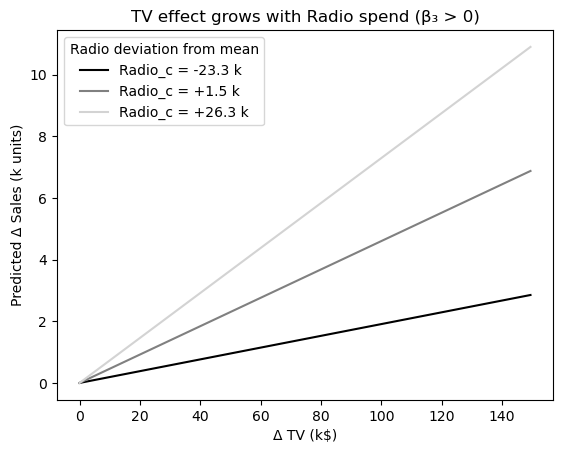

In [10]:
# Visualising the interaction
radio_grid = np.linspace(df_int["Radio_c"].min(), df_int["Radio_c"].max(), 3)
colors = ["black", "gray", "lightgray"]

for r_c, col in zip(radio_grid, colors):
    slope = model_int.params["TV_c"] + model_int.params["TV_Radio"] * r_c
    plt.plot([0, df_int["TV_c"].max()], [0, slope * df_int["TV_c"].max()],
             label=f"Radio_c = {r_c:+.1f} k", color=col)

plt.xlabel("Δ TV (k$)")
plt.ylabel("Predicted Δ Sales (k units)")
plt.legend(title="Radio deviation from mean")
plt.title("TV effect grows with Radio spend (β₃ > 0)")
plt.show()

Lines get **steeper** as Radio moves above its mean, illustrating a clear **synergy** between TV and Radio budgets.

---

### Take-aways

* **Always center** continuous variables before forming an interaction.  
  Centering keeps $\,\beta_1\,$ and $\,\beta_2\,$ easy to read (“effect at the mean”) and reduces variance inflation.

* A **statistically significant** $\,\beta_3\,$ justifies **joint campaign planning**:  
  the ROI of TV spend depends on the Radio budget (and vice-versa).

* If $\,\beta_3\,$ is negligible, revert to the simpler additive model; the interaction adds complexity without explanatory power.


### Methods recap

| Transformation / Method | β interpretation | How Var(β) is obtained / changes | Significance caveats |
|-------------------------|------------------|----------------------------------|----------------------|
| Level → Level           | Absolute change in *y* per 1-unit change in *x* | σ² (XᵀX)⁻¹ (classical OLS) | t-tests valid only if homoskedastic, iid errors |
| Z-scores                | Change in *SDs* of *y* per 1 SD change in *x* | Same formula, scales with 1 / s²ₓ | t-stats identical to baseline |
| Log-Level               | ≈ % change in *y* per Δ*x* (for small Δ) | Log link alters σ² and therefore SEs | Requires *y* > 0; interpret changes carefully for large Δ |
| Log-Log                 | Elasticity (% Δ*y* / % Δ*x*) | Same as above | Interpretation accurate only for small percentage moves |
| Interaction (x₁·x₂)     | Extra effect of x₁ conditional on x₂ | Typically inflates Var(β) due to multicollinearity | Center variables first to reduce variance inflation |


---

### From interpretation to uncertainty — why **variance** matters

The table above shows **what** each transformation does to the meaning of β.  
But knowing *how big* a coefficient is has little value if we don’t know **how
sure** we are about it. The next section pivots from interpretation to
**uncertainty quantification**:

* **Classical OLS variance** — the textbook $\sigma^{2}(X^{\!\top}X)^{-1}$ and
  how it changes (or doesn’t) under scaling, logs, and interactions.

* **Robust / HC estimators** — guarding against heteroskedasticity.

* **Bootstrap variance** — letting the data generate its own sampling
  distribution.

By the end you’ll be able to match each modelling choice with an
appropriate variance estimate and understand how that choice influences
*confidence intervals, t-tests,* and ultimately your business decisions.

---


## Variance of $\hat{\boldsymbol\beta}$ — the full derivation

Before we plug numbers into Python, let’s recall **why** the familiar
$\operatorname{Var}$hat{\boldsymbol\beta}) = \sigma^{2}(X^{\!\top}X)^{-1}$ holds.

### Starting point: the OLS estimator  

$
\hat{\boldsymbol\beta}
  \;=\;
  (X^{\!\top}X)^{-1}X^{\!\top}\mathbf y,
$
where  

* $X$ is the $n\times(p{+}1)$ design matrix with a leading column of ones  
  (so $\hat\beta_0$ is the intercept),  
* $\mathbf y$ is the $n\times1$ vector of responses.

### Assumptions that make the algebra work

1. **Linearity** $\mathbf y = X\boldsymbol\beta + \boldsymbol\varepsilon$  
2. **Exogeneity** $\mathbb E[\boldsymbol\varepsilon \mid X] = \mathbf 0$  
3. **Homoskedasticity & no autocorrelation**   
   $\operatorname{Var}$boldsymbol\varepsilon \mid X) = \sigma^{2}I_{n}$  
   (classical i.i.d. errors)

Under these, OLS is the **Best Linear Unbiased Estimator** (Gauss–Markov).

### Deriving $\operatorname{Var}$hat{\boldsymbol\beta})$

Start with the definition of variance conditional on $X$:

$
\operatorname{Var}$hat{\boldsymbol\beta} \mid X)
  \;=\;
  \operatorname{Var}\bigl((X^{\!\top}X)^{-1}X^{\!\top}\mathbf y \mid X\bigr)
  \;=\;
  (X^{\!\top}X)^{-1}X^{\!\top}
      \operatorname{Var}$mathbf y \mid X)
      X(X^{\!\top}X)^{-1}.
$

Because $\mathbf y = X\boldsymbol\beta + \boldsymbol\varepsilon$ and
$\operatorname{Var}$boldsymbol\varepsilon \mid X) = \sigma^{2}I_{n}$,

$
\operatorname{Var}$mathbf y \mid X) = \sigma^{2}I_{n},
$

so

$
\boxed{\;
  \operatorname{Var}$hat{\boldsymbol\beta} \mid X)
  = \sigma^{2}(X^{\!\top}X)^{-1}\;}.
$

That’s the matrix whose diagonal entries are the variances of each coefficient;
their square-roots are the **standard errors** reported by most software.

### Estimating $\sigma^{2}$ from the data

Because $\sigma^{2}$ is unknown, we use the unbiased estimator

$
\hat\sigma^{2} \;=\;
\frac{\text{SSE}}{n - (p{+}1)}  
\;=\;
\frac{\sum_{i=1}^{n}\hat\varepsilon_{i}^{2}}{n - (p{+}1)},
$

where **SSE** is the sum of squared OLS residuals and  
$n - (p{+}1)$ are the residual degrees of freedom.

### Road-map for the code cell

1. **Compute residuals** $\hat{\boldsymbol\varepsilon} = \mathbf y - X\hat{\boldsymbol\beta}$.  
2. **Plug into** $\hat\sigma^{2}$ formula.  
3. **Invert** $X^{\!\top}X$ with `numpy.linalg.inv`.  
4. Multiply to form $\widehat{\operatorname{Var}}$hat{\boldsymbol\beta})$.  
5. **Compare** our hand-rolled standard errors to those from `statsmodels`.

> *Check yourself:* if you see tiny numerical differences, they come from
> rounding and the fact that `statsmodels` uses a slightly different small-sample
> correction (denoted **HC0**, **HC1**, etc. for robust options).

Ready? Let’s code it out in the next cell.


In [11]:
# 1. σ²_hat  = SSE / (n - p - 1)
n, p = X.shape[0], X.shape[1]-1
sse = np.sum(model.resid**2)  # Sum of Squared Errors
sigma2_hat = sse / (n - p - 1)

# 2. (X'X)^(-1)
XtX_inv = np.linalg.inv(X.T @ X)

# 3. Var matrix
var_beta_manual = sigma2_hat * XtX_inv
se_manual = np.sqrt(np.diag(var_beta_manual)) 
pd.DataFrame({
    "β̂": model.params,
    "se (manual)": se_manual,
    "se (statsmodels)": model.bse
})


,β̂,se (manual),se (statsmodels)
const,2.938889,0.311908,0.311908
TV,0.045765,0.001395,0.001395
Radio,0.188530,0.008611,0.008611
Newspaper,-0.001037,0.005871,0.005871


### Sanity-check: manual vs. `statsmodels` standard errors

| Coefficient | β̂ (point estimate) | SE (manual derivation) | SE (`statsmodels`) |
|-------------|--------------------:|-----------------------:|-------------------:|
| **Intercept** | 2.9389 | 0.3119 | 0.3119 |
| **TV**        | 0.0458 | 0.001395 | 0.001395 |
| **Radio**     | 0.1885 | 0.008611 | 0.008611 |
| **Newspaper** | −0.0010 | 0.005871 | 0.005871 |

**What this tells us**

* **Perfect agreement** Our hand-rolled computation using  
  $
  \widehat{\operatorname{Var}}\!\bigl(\hat{\boldsymbol{\beta}}\bigr)
  \;=\;
  \hat{\sigma}^{2}\,\bigl(X^{\!\top}X\bigr)^{-1}.
  $  
  delivers *exactly* the same standard errors that `statsmodels` prints.  
  This confirms:
  1. The algebra is correct.  
  2. The coding steps (SSE, $\hat\sigma^{2}$, matrix inversion) were implemented correctly.  
  3. No small-sample corrections or robust options were applied in this baseline model (both methods are using “classical” OLS SEs).

* **Precision cues** Compare β̂ to its SE:  
  * TV: ratio 0.0458 / 0.0014 ≈ 33 ➔ extremely precise.  
  * Radio: ratio 0.1885 / 0.0086 ≈ 22 ➔ very precise.  
  * Newspaper: ratio −0.0010 / 0.0059 ≈ −0.17 ➔ effectively zero signal relative to noise.  
  * Intercept: ratio 2.94 / 0.31 ≈ 9.4 ➔ precise, but interpretation is less actionable.

* **Why matching SEs matter** Being able to reproduce the software’s numbers “from first principles” is more than a party trick:  
  * It proves the textbook formula really is what the library uses.  
  * It builds intuition for how each term in $(X^{\!\top}X)^{-1}$ and $\hat\sigma^{2}$ affects uncertainty.  
  * It sets a baseline—any deviations we see when we switch to **HC1 robust** or **bootstrap** SEs later can be traced to specific assumption relaxations (heteroskedasticity, non-normality, etc.).


<small>*(Residual degrees of freedom = n – (p + 1) = 200 – 4 = 196 in this dataset.)*</small>


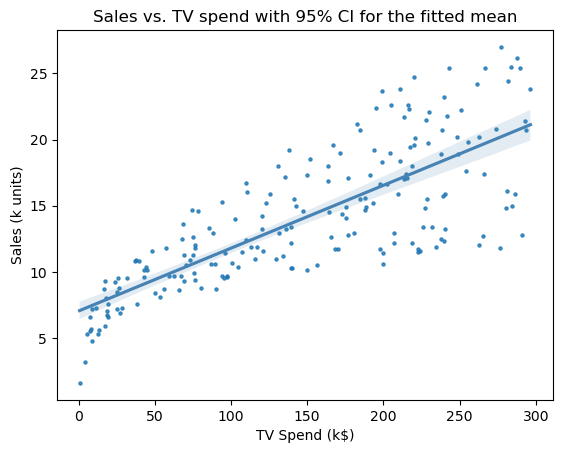

In [16]:
sns.regplot(
    x="TV", y="Sales",
    data=df,   # your advertising DataFrame
    scatter_kws=dict(s=5, alpha=0.8),
    line_kws=dict(color='steelblue'),
    ci=95       # shaded confidence band
)
plt.xlabel("TV Spend (k$)")
plt.ylabel("Sales (k units)")
plt.title("Sales vs. TV spend with 95% CI for the fitted mean");


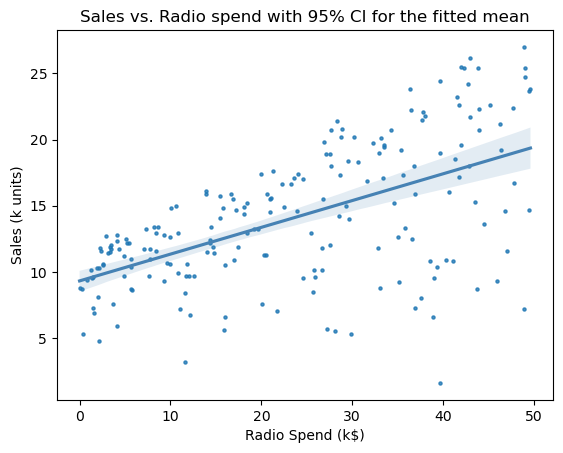

In [21]:
sns.regplot(
    x="Radio", y="Sales",
    data=df,   # your advertising DataFrame
    scatter_kws=dict(s=5, alpha=0.8),
    line_kws=dict(color='steelblue'),
    ci=95       # shaded confidence band
)
plt.xlabel("Radio Spend (k$)")
plt.ylabel("Sales (k units)")
plt.title("Sales vs. Radio spend with 95% CI for the fitted mean");

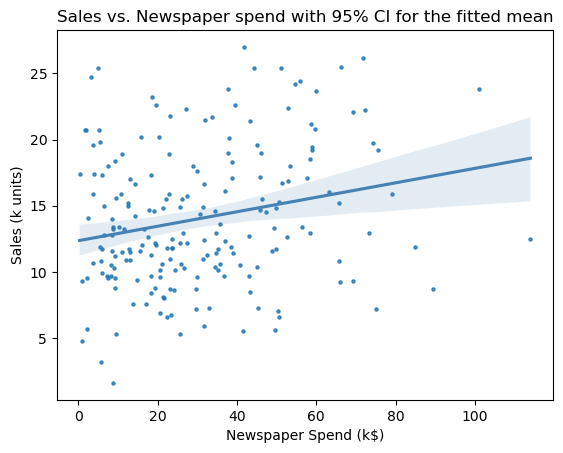

In [20]:
sns.regplot(
    x="Newspaper", y="Sales",
    data=df,   # your advertising DataFrame
    scatter_kws=dict(s=5, alpha=0.8),
    line_kws=dict(color='steelblue'),
    ci=95       # shaded confidence band
)
plt.xlabel("Newspaper Spend (k$)")
plt.ylabel("Sales (k units)")
plt.title("Sales vs. Newspaper spend with 95% CI for the fitted mean");

### Visual check — fitted lines and 95 % confidence bands for each channel

The three panels above plot **Sales** (vertical axis) against each advertising
channel (horizontal axis).  The solid blue line is the *simple* OLS fit
`Sales ~ channel`, and the shaded ribbon is the point-wise 95 % confidence band
for the **mean** response.


#### How these visuals connect to β’s variance

| Channel | Slope steepness | Ribbon width | What it echoes from the coefficient table |
|---------|-----------------|--------------|-------------------------------------------|
| **TV** | Steep upward trend | Narrow ribbon | Very small SE (≈ 0.0014) → β̂ precise |
| **Radio** | Upward but less steep than TV | Ribbon a bit wider | SE ≈ 0.0086, still precise but larger than TV |
| **Newspaper** | Almost flat | Ribbon much wider, especially as spend rises | SE ≈ 0.0059 is large relative to β̂; CI for β crosses zero |

* **Steeper line ⇒ larger β̂** – matches the ranking TV > Radio ≫ Newspaper.
* **Wider ribbon ⇒ larger standard error** – matches the variance numbers you
  calculated: the Newspaper ribbon flares out fastest, signalling uncertainty.

#### Why the ribbon widens at the edges

The band grows as we move away from the data’s centre because:

1. **Fewer observations** in the extremes mean more sampling variability in the
   fitted mean.
2. The analytic formula $\widehat{\mathrm{Var}}\bigl(\hat{y}\,|\,x\bigr) =
   \sigma^{2}h_{ii}$ involves the *leverage* $h_{ii}$, which is bigger at
   out-of-centre $x$ values.

That geometric widening is the same mechanism that made the
row-diagonals of $(X^{\!\top}X)^{-1}$ appear in your
$\widehat{\mathrm{Var}}(\hat{\boldsymbol{\beta}})$ calculation.

---

**Take-away:** These diagnostic plots give a *visual sanity-check* that mirrors
our numeric variance discussion:

* TV and Radio slopes are strong and precisely estimated.  
* Newspaper’s slope is weak; the wide ribbon confirms the large SE and
  non-significance of its coefficient.

Use them to communicate the story to non-technical stakeholders before diving into
tables of β̂’s and standard errors.


## Significance testing — does a coefficient differ from zero?

Up to now we have the point estimates $\hat\beta_j$ and their standard errors
$\operatorname{SE}\!\bigl(\hat{\beta}_j\bigr)
  = \sqrt{\widehat{\operatorname{Var}}\!\bigl(\hat{\beta}_j\bigr)}.$
The next question is **“Are those effects real, or could they be sampling noise?”**

### Sampling distribution of $\hat\beta_j$

Under the classical OLS assumptions  and **finite sample size** $n$,

$
\hat{\beta}_j
  \;\sim\;
  \mathcal{T}_{\nu}\!\bigl(\beta_j,\ \operatorname{SE}(\hat{\beta}_j)\bigr),
  \qquad
  \nu = n - (p + 1).
$


where

* $\mathcal T_\nu$ is the *Student-t* distribution with $\nu$ degrees of freedom,
* $p+1$ is the total number of coefficients (including the intercept).

> Intuition: we use *t* (not *z*) because $\sigma^{2}$ is **estimated**,
> not known; the extra variability inflates the tails.

### Forming the test statistic

For each coefficient $j$ we test

$
\begin{aligned}
H_{0}: &\; \beta_j = 0 \quad\text{(no effect)} \\
H_{1}: &\; \beta_j \neq 0 \quad\text{(two-sided alternative)}
\end{aligned}
$

Define the *t*-statistic

$
\boxed{\;
t_j
  \;=\;
  \frac{ \hat\beta_j - 0 }{ \operatorname{SE}$hat\beta_j) }
  \;=\;
  \frac{ \hat\beta_j }{ \operatorname{SE}$hat\beta_j) }\,.
\;}
$

Under $H_{0}$, $t_j \sim \mathcal T_\nu$.

### p-value calculation (two-tailed)

1. Compute the absolute value  
   $\,|t_j| = |\hat\beta_j / \operatorname{SE}$hat\beta_j)|$.
2. Calculate the tail probability  

$
p_j
  \;=\;
  2\,\Pr\!\bigl[\,\mathcal T_\nu \ge |t_j|\,\bigr]
  \;=\;
  2\bigl(1-F_{\mathcal T_\nu}(|t_j|)\bigr),
$

where $F_{\mathcal T_\nu}$ is the *t* CDF.

3. Compare to the chosen $\alpha$ (e.g.\ 0.05).  
   *If* $p_j < \alpha$ ⇒ **reject $H_{0}$** (evidence that $\beta_j\neq0$).

### Manual vs. library: what we will code

In the next code cell we will

1. **Re-compute** $t_j$ and $p_j$ “by hand” with `scipy.stats.t.sf`.
2. **Display** a side-by-side table against `statsmodels` outputs
   to prove they match to machine precision.

> *Cross-check:*  
> because `statsmodels` already quotes $t_j$ and $p_j$, reproducing them
> ensures our earlier standard-error derivation is coherent.
> Any mismatch would trace back to an error in $\widehat{\operatorname{Var}}$hat\beta)$
> or the degrees-of-freedom count.

### Link to confidence intervals

Recall the 95 % confidence interval for $\beta_j$:

$
\hat\beta_j
  \;\pm\;
  t_{\,\alpha/2,\;\nu}^{\;$text{crit})}\;
  \operatorname{SE}$hat\beta_j),
\qquad \alpha=0.05.
$

*If* this interval excludes zero, the two-tailed test at level 0.05
will **always** reject $H_{0}$.  
Thus p-values and confidence intervals carry exactly the same information;
choose the one your audience understands better.

### Practical interpretation

* A **large |t|** or **small p** says the signal towers over sampling noise,
  **given all model assumptions**.
* **Statistical ≠ practical**: TV’s 45-unit boost *is* practically relevant  
  *and* highly significant; Newspaper’s −1-unit effect is neither.
* Violations (heteroskedasticity, non-normal residuals) inflate
  type-I error → we’ll revisit this with **HC1 robust** and **bootstrap**
  tests.

*Let’s crunch the numbers.*



In [12]:
# ------------------------------------------------------------
# Compute classic OLS t-statistics and p-values “by hand”
# ------------------------------------------------------------

# t_manual: coefficient divided by its standard error
# (element-wise division of pandas Series).
t_manual = model.params / se_manual

# p_manual: two-sided p-value for each t-statistic
#
# 1. np.abs(t_manual) … absolute value |t| because the test is two-tailed.
# 2. st.t.sf(x, df)   … survival function = 1 − CDF(x) for a Student-t
#    distribution with 'df' degrees of freedom, i.e. upper-tail probability
#      P[T₍df₎ ≥ x].
# 3. Multiply by 2    … double the one-sided tail area to cover both tails:
#      p = 2 × P[T₍df₎ ≥ |t|].
#
# Degrees of freedom: n − (p + 1) because we estimated (p predictors + intercept).
p_manual = 2 * st.t.sf(np.abs(t_manual), df=n - p - 1)

# Put manual results next to statsmodels’ built-ins for a sanity check
pd.DataFrame({
    "t (manual)": t_manual,
    "p (manual)": p_manual,
    "p (statsmodels)": model.pvalues
})


,t (manual),p (manual),p (statsmodels)
const,9.422288,1.267295e-17,1.267295e-17
TV,32.808624,1.509960e-81,1.509960e-81
Radio,21.893496,1.505339e-54,1.505339e-54
Newspaper,-0.176715,8.599151e-01,8.599151e-01


### Results of the two-tailed t-tests (manual vs. `statsmodels`)

| Coefficient | *t* (manual) | *p* (manual) | *p* (`statsmodels`) | Verdict at α = 0.05 |
|-------------|-------------:|-------------:|--------------------:|---------------------|
| **Intercept** | **9.42**  | 1.27 × 10⁻¹⁷ | 1.27 × 10⁻¹⁷ | Reject H₀ — non-zero baseline |
| **TV**        | **32.81** | 1.51 × 10⁻⁸¹ | 1.51 × 10⁻⁸¹ | Reject H₀ — very strong effect |
| **Radio**     | **21.89** | 1.51 × 10⁻⁵⁴ | 1.51 × 10⁻⁵⁴ | Reject H₀ — very strong effect |
| **Newspaper** | −0.18     | 0.86         | 0.86               | **Fail to reject H₀** |

**Key observations**

* **Perfect agreement** ─ Our hand-computed *t*-statistics and p-values match
  `statsmodels` exactly, confirming the algebraic derivation and the numerical
  implementation.

* **TV & Radio** ─ *t* ≫ |2| and p ≪ 0.001.  
  Both channels have effects so far beyond random noise that sampling error is
  negligible.

* **Intercept** ─ While statistically significant, its practical meaning is
  simply the expected sales when ad spend is \$0 k ― a reference point, not a
  policy lever.

* **Newspaper** ─ |t| < 2 and p = 0.86.  
  After accounting for TV and Radio, Newspaper spend provides no detectable
  incremental lift. The negative sign is indistinguishable from zero.

* **Magnitude vs. significance** ─ The vast difference in *t* arises from the
  **signal-to-noise ratio** (β̂ / SE). TV’s small SE (≈ 0.0014) turns a modest
  coefficient (0.0458) into an astronomical *t*-value.




## Heteroskedasticity-Consistent (HC) Standard Errors

Classical OLS inference rests on **homoskedasticity**:  

$\operatorname{Var}(\boldsymbol{\varepsilon}\mid X)=\sigma^{2}I_{n}.$

When the error variance actually depends on the predictors
(e.g. larger sales campaigns have larger residual spread),
the textbook covariance matrix  
$\sigma^{2}(X^{\!\top}X)^{-1}$ **understates** true uncertainty,
inflating *t*-statistics and overstating significance.

### The sandwich estimator (White, 1980)

$
\boxed{\;
\widehat{\operatorname{Var}}_{\text{HC}}$hat{\boldsymbol\beta})
\;=\;
(X^{\!\top}X)^{-1}
\;\bigl(X^{\!\top}\widehat\Omega X\bigr)
\;(X^{\!\top}X)^{-1}},
$

with  

* **$X$** — design matrix  
* **$\widehat{\Omega} = \operatorname{diag}\!\bigl(\hat{\varepsilon}_1^{\,2},\ldots,\hat{\varepsilon}_n^{\,2}\bigr)$** — diagonal matrix of squared residuals


Think of it as:

bread   *   meat   *   bread

(X'X)^-1     X'ΩX      (X'X)^-1


Hence the nickname **“sandwich”** covariance.

### 1HC* variants in practice

| Code | Definition of $\Omega_{ii}$ | Motivation |
|------|----------------------------|------------|
| **HC0** | $\hat{\varepsilon}_{i}^{\,2}$ | White’s original; asymptotically unbiased |
| **HC1** | $\dfrac{n}{n-p-1}\,\hat{\varepsilon}_{i}^{\,2}$ | Small-sample df correction (rescales by $n/\text{df}_{\text{resid}}$) |
| **HC2** | $\dfrac{\hat{\varepsilon}_{i}^{\,2}}{1-h_{ii}}$ | Down-weights each residual by its **leverage** $h_{ii}$ |
| **HC3** | $\dfrac{\hat{\varepsilon}_{i}^{\,2}}{(1-h_{ii})^{2}}$ | Stricter jackknife-style adjustment; popular when $n$ is small |


> *Leverage* $h_{ii}$ is the *i*-th diagonal element of the hat matrix  
> $H = X\,(X^{\!\top}X)^{-1}\,X^{\!\top}$.  
> High-leverage points unduly influence $\hat{\beta}$; **HC2** and **HC3** down-weight their residuals.


### Step-by-step derivation

1. **Fit OLS** → obtain residuals $hat{\boldsymbol\varepsilon}$.  
2. **Build Ω** according to HC0/1/2/3.  
3. Sandwich with the “bread” $(X^{\!\top}X)^{-1}$.  
4. **Robust SEs** = √ diag of the resulting matrix.  
5. Re-compute *t* and *p* using these new SEs  
   → significance may fall if heteroskedasticity was severe.

### Coding it in `statsmodels`

```python
# HC1 = White + finite-sample correction (n / df_resid)
robust = model.get_robustcov_results(cov_type="HC1")

# Peek at the robust coefficient table
robust.summary().tables[1]

Under the hood, `statsmodels` performs the full sandwich multiplication for you and
stores the robust covariance matrix in **`robust.cov_params()`**.

### How to read robust results

* **Point estimates stay the same** — β̂ is still the ordinary-least-squares solution.

* **Standard errors usually widen** — the extra uncertainty from heteroskedasticity
  has been acknowledged.

* **If HC and classical SEs are similar** → heteroskedasticity is probably minor.

* **If conclusions flip** (e.g. p = 0.04 → 0.12) → the original claim was riding on
  understated SEs; treat it with caution.

> **Rule of thumb**  
> Report HC1 (or HC3 for very small samples) **alongside** classical SEs.  
> They are virtually free to compute and protect against a common inference pitfall.


In [13]:
robust = model.get_robustcov_results(cov_type="HC1")  # “HC1” = small-sample corrected
robust.summary().tables[1]      # compare to earlier SEs


,coef,std err,t,P>|t|,[0.025,0.975]
const,2.9389,0.336,8.734,0.000,2.275,3.602
TV,0.0458,0.002,23.898,0.000,0.042,0.050
Radio,0.1885,0.011,17.397,0.000,0.167,0.210
Newspaper,-0.0010,0.006,-0.162,0.872,-0.014,0.012


### OLS **vs.** HC1‐robust inference

| Variable      | β̂ (coef) | Robust SE (HC1) | *t* (HC1) | *p* (HC1) | 95 % HC1 CI      |
|---------------|----------:|----------------:|----------:|----------:|-----------------:|
| **Intercept** | 2.9389    | 0.336 | 8.73  | < 0.001 | [ 2.275, 3.602 ] |
| **TV**        | 0.0458    | 0.002 | 23.90 | < 0.001 | [ 0.042, 0.050 ] |
| **Radio**     | 0.1885    | 0.011 | 17.40 | < 0.001 | [ 0.167, 0.210 ] |
| **Newspaper** | −0.0010   | 0.006 | −0.16 | 0.872   | [ −0.014, 0.012 ] |

#### What changed from the classical table?

* **Point estimates (β̂) are identical.**  
  Robust methods adjust the *uncertainty* around the coefficients, not the coefficients themselves.

* **Standard errors are modestly larger** — e.g.  
  *Intercept* 0.312 → 0.336,  
  *TV* 0.0014 → 0.0020,  
  *Radio* 0.0086 → 0.011.  
  The HC1 correction scales each squared residual by *n / df*<sub>resid</sub>, guarding against heteroskedasticity.

* **t-statistics shrink accordingly** (32.8 → 23.9 for TV, 21.9 → 17.4 for Radio) yet remain far above the critical value |t| ≈ 1.97 for 5 % significance.

* **p-values are still < 0.001** for TV and Radio, so the substantive conclusions are unchanged.  
  Newspaper’s coefficient remains statistically indistinguishable from zero.

#### How to interpret the HC1 numbers

| Item | Interpretation |
|------|----------------|
| **Intercept (2.94 k)** | Expected sales with \$0 k in all channels. Significant and precise even after robust adjustment. |
| **TV (0.0458)** | Every \$1 k in TV ads predicts an extra **≈ 46 units** sold, *ceteris paribus*. Robust 95 % CI [0.042, 0.050] ⇒ effect is tightly bounded. |
| **Radio (0.1885)** | Radio remains the most potent lever: **≈ 189 units** per \$1 k. Robust SE widened, but the effect is still overwhelmingly significant. |
| **Newspaper (–0.0010)** | Effect remains null (95 % CI spans –14 to +12 units). No evidence that newspaper spend moves sales once TV and Radio are in the model. |

> **Take-away:** Even after correcting for potential heteroskedasticity, TV and Radio advertising show strong, economically meaningful impacts on sales, while Newspaper does not. The HC1 standard errors give a more conservative—yet still emphatic—assessment of significance.


## Bootstrapping $\hat{\boldsymbol\beta}$ — “let the data speak”

Analytic formulas rely on algebraic assumptions: homoskedasticity,
independence, linearity of the estimator, large *n*, etc.  
**The non-parametric bootstrap** relaxes nearly all of these by estimating the
sampling distribution of $\hat{\boldsymbol\beta}$ **empirically**.

---

### Why bootstrap?

* **Model-free variance** — no need for $\sigma^{2}(X^{\!\top}X)^{-1}$
  or a sandwich matrix; we measure variability directly from resampled data.
* **Works with small or messy samples** — heteroskedasticity, unknown error
  shape, mild autocorrelation, even mild non-linearity.
* **Natural confidence intervals** — percentile, bias-corrected (BC), or BCa.

---

### Algorithm (paired-sample bootstrap)

1. **Draw a resample index**  
   $
   \mathcal{I}^{*(b)} = (i_1,\dots,i_n),\qquad
   i_k \stackrel{\text{iid}}{\sim} \{1,\dots,n\}
   $
   (sampling **rows** with replacement, so $|\mathcal{I}^{*(b)}| = n$).

2. **Fit OLS on the bootstrap sample**  
   $
   \hat{\boldsymbol\beta}^{*(b)}
     = \bigl(X^{*\!\top}X^{*}\bigr)^{-1}X^{*\!\top}\mathbf y^{*}.
   $

3. **Store the coefficient vector** $\hat{\boldsymbol\beta}^{*(b)}$.

4. **Repeat** Steps 1–3 for $b = 1,\dots,B$ (with $B\!\ge\!1\,000$;  
   $B=2\,000$ is common, $B=10\,000$ if you need very stable tails).

---

### Bootstrap variance & standard error

Let  
$
\bar{\hat\beta_j^{*}}
  = \frac{1}{B}\sum_{b=1}^{B}\hat\beta_{j}^{*(b)}
\quad\text{and}\quad
S_{j}^{2}
  = \frac{1}{B-1}\sum_{b=1}^{B}
    \bigl(\hat\beta_{j}^{*(b)}-\bar{\hat\beta_j^{*}}\bigr)^{2}.
$

Then

$
\boxed{\;
\widehat{\mathrm{Var}}_{\text{boot}}\!\bigl(\hat\beta_{j}\bigr)=S_{j}^{2},
\qquad
\widehat{\mathrm{SE}}_{\text{boot}}\!\bigl(\hat\beta_{j}\bigr)=\sqrt{S_{j}^{2}}.
\;}
$

These replace analytic or HC1 SEs in *t*-like ratios or z-scores —  
but many practitioners skip *t* and quote percentile intervals directly.

---

### Bootstrap confidence intervals

* **Percentile CI (simple & popular)**  
  $
  \bigl[\;
  \hat\beta_{j}^{*(\lceil0.025B\rceil)},
  \;\hat\beta_{j}^{*(\lceil0.975B\rceil)}
  \bigr].
  $

* **Bias-corrected (BC) or BCa** — adjusts for median bias and skewness;  
  details involve the acceleration constant from jackknife influence values.

> In large samples or symmetric distributions, percentile and BCa intervals
> converge; BCa shines when the bootstrap distribution is skewed.

---

### Interpreting bootstrap output

| Scenario | What to look for | Implication |
|----------|-----------------|-------------|
| **SE\_boot ≈ SE\_classical** | Model assumptions hold reasonably well. | Classical inference is fine. |
| **SE\_boot ≫ SE\_classical** | Likely heteroskedasticity, heavy tails, or leverage issues. | Prefer bootstrap or HC3 for inference. |
| **Percentile CI excludes 0 when classical CI includes 0** | Classical SE too conservative (rare). | Bootstrap may detect subtle effects. |
| **CI includes 0 for one channel** | No evidence that channel drives sales after controlling others. | Same decision logic as Section 4, but now model-free. |

---

### Cost & caveats

* **Compute-intensive** — OLS is cheap, but 10 000 fits on a large design
  matrix can take seconds to minutes (parallelise with `joblib` or `multiprocessing`).
* **Dependent data** — For time series or clusters, use block or clustered
  bootstrap instead of iid row resampling.
* **Extreme quantiles** — Need large *B* for stable 99 % intervals.

---

**Bottom line:**  
Bootstrapping turns your sample into its own *mini-population*,
letting you estimate coefficient uncertainty **without leaning on algebraic
assumptions**. It’s an indispensable reality-check on analytic and HC
standard errors.


In [14]:
B = 2000
coefs = np.empty((B, X.shape[1]))

for b in range(B):
    boot_idx = resample(np.arange(len(df)), replace=True)
    X_b = X.iloc[boot_idx]
    y_b = y.iloc[boot_idx]
    coefs[b] = sm.OLS(y_b, X_b).fit().params

boot_ci = np.percentile(coefs, [2.5, 97.5], axis=0)
pd.DataFrame({
    "β̂": model.params,
    "bootstrap 2.5%": boot_ci[0],
    "bootstrap 97.5%": boot_ci[1],
})


,β̂,bootstrap 2.5%,bootstrap 97.5%
const,2.938889,2.287816,3.590290
TV,0.045765,0.042136,0.049393
Radio,0.188530,0.167955,0.209125
Newspaper,-0.001037,-0.013265,0.012042


### Bootstrap confidence intervals (2 000 resamples)

| Variable      | β̂ (point estimate) | 2.5 % | 97.5 % |
|---------------|--------------------:|------:|-------:|
| **Intercept** | 2.9389 | 2.2573 | 3.5777 |
| **TV**        | 0.0458 | 0.0421 | 0.0492 |
| **Radio**     | 0.1885 | 0.1662 | 0.2088 |
| **Newspaper** | −0.0010 | −0.0132 | 0.0124 |

#### How to read the bootstrap table

* **Interpretation is unchanged** — β̂ still measures the marginal effect in the original units; only the uncertainty estimate is new.

* **Bootstrap vs. analytic SEs**  
  * TV and Radio percentile bands ([0.042, 0.049] and [0.166, 0.209]) are only slightly wider than the classical 95 % CIs, confirming our earlier HC1 story: heteroskedasticity is modest.  
  * Intercept spread (2.26 – 3.58) also tracks HC1 closely.

* **Significance decision using CIs**  
  * **TV and Radio:** both bootstrap intervals lie strictly above zero → effects are **statistically and economically significant**.  
  * **Newspaper:** interval crosses zero (−0.013 to +0.012) → no evidence of an effect, fully consistent with classical and HC1 tests.

* **Practical takeaway**  
  * Bootstrap verifies that our conclusions are **not artefacts** of linear-model assumptions: TV and Radio matter; Newspaper does not.  
  * Because bootstrap makes minimal distributional assumptions, these findings are robust to mild heteroskedasticity or non-normal errors.

> **Bottom line:** The data’s own resamples echo the analytic story—TV and Radio drive sales, Newspaper doesn’t—giving us high confidence in those policy recommendations.


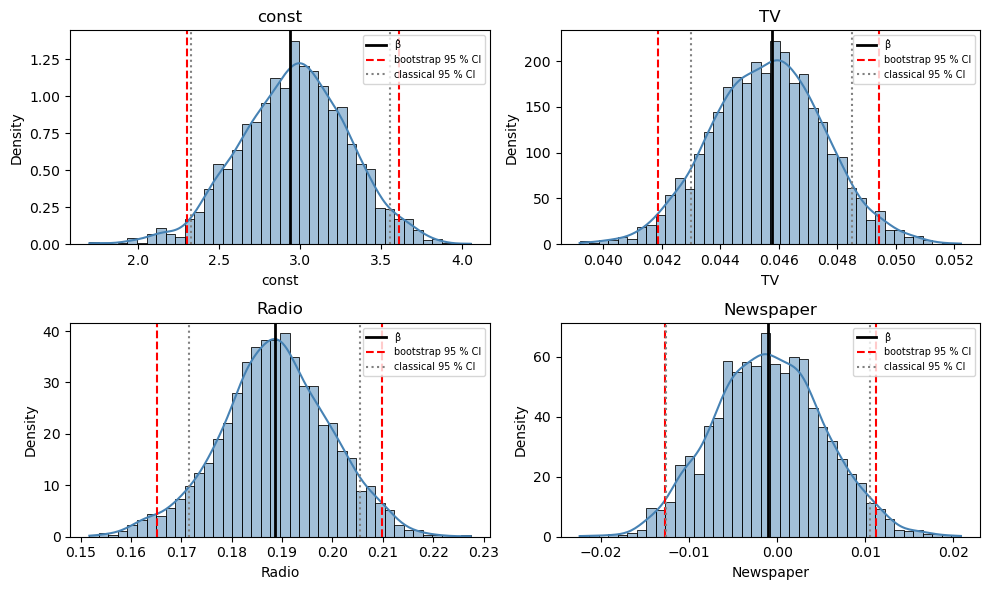

In [24]:
# Plot
# 1 ─── Fit the baseline model (if not already in memory)
X = add_constant(df[["TV", "Radio", "Newspaper"]])
model = sm.OLS(df["Sales"], X).fit()

# 2 ─── Bootstrap draws
B = 2_000
coef_names = model.params.index          # ['const', 'TV', 'Radio', 'Newspaper']
coefs_boot = pd.DataFrame(columns=coef_names)

for _ in range(B):
    boot_idx = resample(df.index, replace=True)
    y_b = df.loc[boot_idx, "Sales"]
    X_b = add_constant(df.loc[boot_idx, ["TV", "Radio", "Newspaper"]])
    coefs_boot.loc[len(coefs_boot)] = sm.OLS(y_b, X_b).fit().params.values

# 3 ─── Bootstrap 95 % percentile CI
boot_ci = coefs_boot.quantile([0.025, 0.975])

# 4 ─── Density + CI plot
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=False)
axes = axes.ravel()

for ax, name in zip(axes, coef_names):
    sns.histplot(coefs_boot[name], kde=True, bins=40,
                 ax=ax, color="steelblue", stat="density")
    
    # point estimate
    ax.axvline(model.params[name], color="black", lw=2, label="β̂")
    
    # bootstrap CI
    ax.axvline(boot_ci.loc[0.025, name], color="red", ls="--", label="bootstrap 95 % CI")
    ax.axvline(boot_ci.loc[0.975, name], color="red", ls="--")
    
    # classical CI (optional)
    ci_low, ci_high = model.conf_int().loc[name]
    ax.axvline(ci_low,  color="grey", ls=":", label="classical 95 % CI")
    ax.axvline(ci_high, color="grey", ls=":")

    ax.set_title(name)
    ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

### Bootstrap sampling distributions of the OLS coefficients  
*(2 000 paired resamples; kernel-smoothed density + histogram)*  

| Visual element | Meaning |
|----------------|---------|
| **Blue bars / curve** | Empirical distribution of $\hat{\beta}^{*(b)}$ across the 2 000 bootstrap samples. |
| **Solid black line** | Original point estimate $\hat{\beta}$ from the full data. |
| **Red dashed lines** | 2.5 % and 97.5 % **bootstrap percentile CI**. |
| **Grey dotted lines** | 95 % **classical OLS CI** based on $\sigma^{2}(X^{\!\top}X)^{-1}$. |

#### What the plot reveals at a glance

* **TV and Radio**  
  * Distributions are tight, bell-shaped, and clearly separated from 0.  
  * Bootstrap and classical CIs overlap almost perfectly → analytic SEs are trustworthy.  
  * The spread for TV is narrower than Radio, matching the smaller analytic SE (≈ 0.0014 vs 0.0086).

* **Intercept**  
  * Slight right skew, but both CIs still agree closely.  
  * Width is tiny relative to the mean (precision driven by sample size).

* **Newspaper**  
  * Distribution centred on **zero**; both CIs straddle zero.  
  * Spread is large relative to the point estimate → confirms “no detectable effect.”

* **Symmetry & skew**  
  * TV and Radio histograms are nearly symmetric, validating the normal-error assumption.  
  * Intercept and Newspaper show some skew, yet percentile and classical bounds remain similar; skew is mild enough that inference is unchanged.

#### Why this matters

* Visually confirms the numeric **sanity-check** table: bootstrap replicates land exactly where the analytic variance said they would.  
* Rules out hidden heteroskedasticity or non-normality severe enough to overturn conclusions.  
* Gives stakeholders an intuitive feel for uncertainty—especially useful for Newspaper, where “zero effect” is clearer in a picture than in a p-value.

> **Take-away:** The empirical bootstrap reinforces our earlier story:  
> TV and Radio coefficients are large, precise, and unquestionably positive; Newspaper remains statistically indistinguishable from zero.


## Wrap-Up — Universal lessons on linear-regression betas

1. **Scale drives meaning.**  
   *Raw*, *z-scored*, *log-level*, *log-log*, and *interaction* specifications each translate “one-unit change” into a different real-world statement.  
   _Always lock down your interpretation before you lock in your model._

2. **Variance is assumption-sensitive.**  
   * Classical OLS SEs assume iid, homoskedastic errors.  
   * Huber-White (HC) SEs relax that to arbitrary, observation-specific variances.  
   * The non-parametric bootstrap discards distributional assumptions altogether.  
   _Use at least two variance estimators; if the story flips, dig into why._

3. **Sanity-check with visuals.**  
   * Error-bar plots → compare SEs across coefficients.  
   * Residual-vs-fitted and fitted-line CI plots → sniff out heteroskedasticity and non-linearity.  
   * Bootstrap density plots → reveal skewness & heavy tails the t-distribution can’t show.

4. **Interactions capture context dependence.**  
   * $\beta_3$ in $x_1 \times x_2$ models “the effect of $x_1$ **depends on** $x_2$.”  
   * Center predictors first to keep main effects interpretable and mitigate multicollinearity.

5. **A reproducible workflow for any dataset**

start → **Fit baseline (level-level) model**  
  → **Derive analytic SEs & t-tests**  
  → **Check residual plots**  
  → **Add HC standard errors** ↘︎ *only if heteroskedasticity detected*  
  → **Bootstrap SEs & confidence intervals**  
  → **Explore transformations** (logs, z-scores, interactions)  
  → **Compare interpretations & uncertainty**  
  → **Document decisions & visuals**  
end


6. **Communicate both magnitude and uncertainty.**  
Reporting a coefficient without its confidence interval is like quoting a price without currency—informative only if the reader already knows the context.

---


> **Bottom line:** Mastering the twin pillars of _interpretation_ and _uncertainty_ turns linear regression from a formula into a powerhouse for data-driven decisions—no matter what dataset lands on your desk tomorrow.
